# Main models

<img src="../images/05.jpg" width="600"/>

Modelos utilizando todo el data.

- [Seguir a partir del checkpoint](#item1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

# Using Activo and Baja for 0 and 1    
class_names = ['Activo','Baja']

pd.options.display.max_columns = None

%matplotlib inline

In [3]:
data = pd.read_excel('../data/portfolio.xlsx')

data['Cliente'] = data['Cliente'].astype('str')
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['Estado'] = data['Estado'].astype('str').str.strip()
data['Estado'] = data['Estado'].replace({'ACTIVO': 0, 'BAJA': 1}).astype(int)

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33


In [4]:
data.shape

(482727, 21)

## Feature engineering

- Edad en Años
- Rango de Ingresos
- Días Activo escalado
- Escalado de 'Quejas', Incidencias y Consumo Mes

Rangos de Edad:

In [5]:
data.columns

Index(['Fecha Alta', 'Cliente', 'Modelo Caldera', 'Provincia', 'Gender',
       'Pais', 'Born Date', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Ingresos', 'Pagos Anuales', 'Fecha Estado', 'Estado',
       'Tipo Inmueble', 'Financiado', 'Precio Contado', 'Precio Total',
       'Quejas', 'Incidencias', 'Consumo Mes'],
      dtype='object')

In [6]:
data['Born Date'].isnull().sum()

1744

In [7]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33


In [8]:
data['Born Date'].isnull().sum()

0

In [9]:
# Edad actual si ACTIVO y edad cuando se dio de baja si BAJA

data['Edad'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Estado'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Fecha Estado'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986


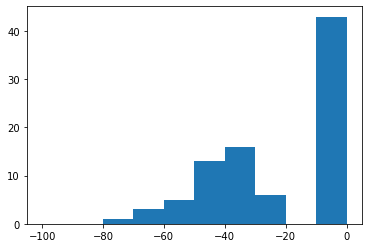

In [10]:
plt.hist(data['Edad'], range = (-100,0));

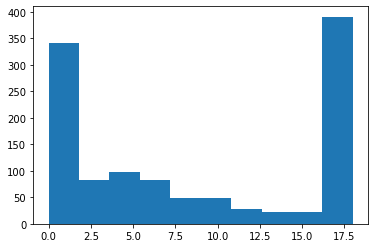

In [11]:
plt.hist(data['Edad'], range = (0,18));

In [12]:
data['Edad'].mean()

52.48552373018186

In [13]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

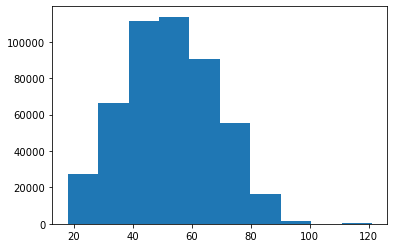

In [14]:
plt.hist(data['Edad']);

In [15]:
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50


In [16]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Rango_Edad,,,,,
+80,15741,2067,17808,0.883929,0.116071
18-30,19229,15106,34335,0.560041,0.439959
30-40,43713,27916,71629,0.610270,0.389730
40-50,80585,30085,110670,0.728156,0.271844
50-60,87688,21351,109039,0.804189,0.195811
60-70,74146,12181,86327,0.858897,0.141103
70-80,47014,5905,52919,0.888414,0.111586
All,368116,114611,482727,0.762576,0.237424


Rangos de Ingresos:

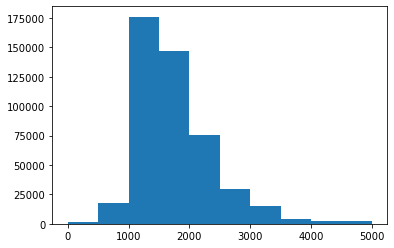

In [17]:
plt.hist(data['Ingresos'], range=(0, 5000));

In [18]:
data.loc[data['Ingresos'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Ingresos'] > 1000) & (data['Ingresos'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Ingresos'] > 1500) & (data['Ingresos'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Ingresos'] > 2000) & (data['Ingresos'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Ingresos'] > 3000, 'Income'] = "+3000"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500


In [19]:
tab1 = pd.crosstab(data["Income"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Income,,,,,
+3000,16635,4219,20854,0.797689,0.202311
0-1000,51940,20045,71985,0.721539,0.278461
1000-1500,169340,54673,224013,0.755938,0.244062
1500-2000,88057,25259,113316,0.777092,0.222908
2000-3000,42144,10415,52559,0.801842,0.198158
All,368116,114611,482727,0.762576,0.237424


Días Activo:

<div class="alert alert-block alert-warning">
<b>Don´t do this!</b> Use checkpoint
</div>

In [20]:
# Días hasta el 19/01/2021 si ACTIVO y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Fecha Alta'])):
    if data.loc[i, 'Estado'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Fecha Alta']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Fecha Estado'] - data.loc[i,'Fecha Alta']).days
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575


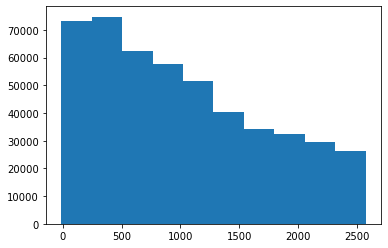

In [21]:
plt.hist(data['Dias_Activo']);

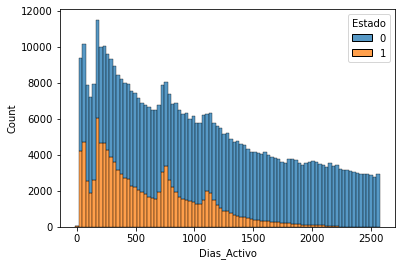

In [22]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Estado', multiple = 'stack');

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Dias_Activo_sca'] = scaler.fit_transform(data['Dias_Activo'].values.reshape(-1, 1))

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640,0.638578
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575,1.000000
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575,1.000000
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575,1.000000
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575,1.000000


In [24]:
filename = '../pkl/dias_activo_sca.pkl'
dias_activo_sca = scaler.fit(data['Dias_Activo'].values.reshape(-1, 1))

pickle.dump(dias_activo_sca, open(filename,'wb'))

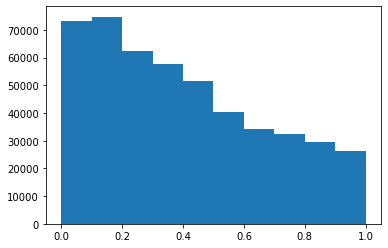

In [25]:
plt.hist(data['Dias_Activo_sca']);

Escalado de Quejas, Incidencias y Consumo Mes:

In [26]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640,0.638578,0.000000
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575,1.000000,0.285714
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575,1.000000,0.000000
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575,1.000000,0.047619
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575,1.000000,0.000000


In [27]:
filename = '../pkl/quejas_sca.pkl'
quejas_sca = scaler.fit(data['Quejas'].values.reshape(-1, 1))

pickle.dump(quejas_sca, open(filename,'wb'))

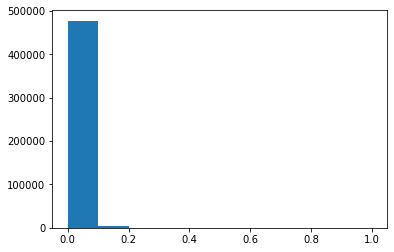

In [28]:
plt.hist(data['Quejas_sca']);

In [29]:
scaler = MinMaxScaler()
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640,0.638578,0.000000,0.000000
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575,1.000000,0.285714,0.235294
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575,1.000000,0.000000,0.000000
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575,1.000000,0.047619,0.000000
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575,1.000000,0.000000,0.000000


In [30]:
filename = '../pkl/incidencias_sca.pkl'
mt_sca = scaler.fit(data['Incidencias'].values.reshape(-1, 1))

pickle.dump(mt_sca, open(filename,'wb'))

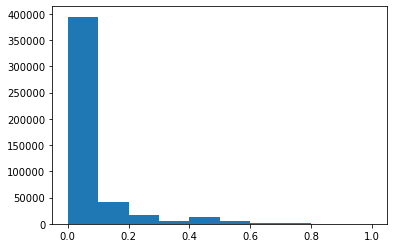

In [31]:
plt.hist(data['Incidencias_sca']);

In [32]:
scaler = MinMaxScaler()
data['Consumo_sca'] = scaler.fit_transform(data['Consumo Mes'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640,0.638578,0.000000,0.000000,0.494132
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575,1.000000,0.285714,0.235294,0.033595
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575,1.000000,0.000000,0.000000,0.054178
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575,1.000000,0.047619,0.000000,0.241246
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575,1.000000,0.000000,0.000000,0.066866


In [33]:
filename = '../pkl/consumo_sca.pkl'
consumo_sca = scaler.fit(data['Consumo Mes'].values.reshape(-1, 1))

pickle.dump(consumo_sca, open(filename,'wb'))

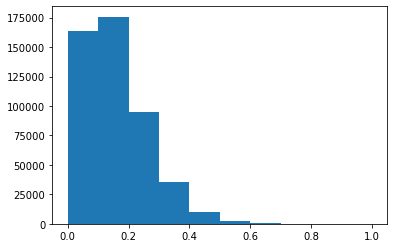

In [34]:
plt.hist(data['Consumo_sca']);

#### Checkpoint `.pkl`

Creación del checkpoint:

In [35]:
filename = '../pkl/data.pkl'

pickle.dump(data, open(filename,'wb'))

<a name="item1"></a>
Carga del checkpoint:

In [143]:
filename = '../pkl/data.pkl'
data = pickle.load(open(filename, 'rb'))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
0,2014-01-01,1,Biasi,Granada,Hombre,España,1959-09-02,Propiedad Parcial,Trabajo Fijo,Casado,2000,13,2018-06-29,1,Casa,Financiado,Promo 0 EUR,399,0,0,622.81,58.863014,50-60,1500-2000,1640,0.638578,0.000000,0.000000,0.494132
1,2014-01-01,2,Biasi,Barcelona,Mujer,España,1971-04-15,Familiar,Parado,Divorciado,600,12,2014-01-01,0,Piso,Financiado,0 - 100 EUR,399,12,4,42.40,49.800000,40-50,0-1000,2575,1.000000,0.285714,0.235294,0.033595
2,2014-01-01,3,Biasi,Madrid,Hombre,España,1968-02-10,Propiedad Total,Trabajo Fijo,Divorciado,2500,14,2014-01-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,68.34,52.978082,50-60,2000-3000,2575,1.000000,0.000000,0.000000,0.054178
3,2014-01-01,4,Biasi,Sevilla,Mujer,España,1968-12-22,Propiedad Parcial,Autonomo,Casado,1800,12,2014-01-01,0,Casa,Financiado,0 - 100 EUR,399,2,0,304.10,52.112329,50-60,1500-2000,2575,1.000000,0.047619,0.000000,0.241246
4,2014-01-01,5,Biasi,Barcelona,Hombre,España,1977-02-22,Propiedad Parcial,Autonomo,Casado,1500,12,2014-01-01,0,Tienda,Financiado,100 - 200 EUR,499,0,0,84.33,43.936986,40-50,1000-1500,2575,1.000000,0.000000,0.000000,0.066866


## Enconding con ``target encoding``

In [144]:
data.columns

Index(['Fecha Alta', 'Cliente', 'Modelo Caldera', 'Provincia', 'Gender',
       'Pais', 'Born Date', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Ingresos', 'Pagos Anuales', 'Fecha Estado', 'Estado',
       'Tipo Inmueble', 'Financiado', 'Precio Contado', 'Precio Total',
       'Quejas', 'Incidencias', 'Consumo Mes', 'Edad', 'Rango_Edad', 'Income',
       'Dias_Activo', 'Dias_Activo_sca', 'Quejas_sca', 'Incidencias_sca',
       'Consumo_sca'],
      dtype='object')

In [145]:
data_filtered = data[['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
                      'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales', 'Dias_Activo_sca',
                      'Quejas_sca', 'Incidencias_sca', 'Consumo_sca', 'Estado']]
data_filtered.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca', 'Estado'],
      dtype='object')

In [146]:
X = data_filtered.drop(['Estado'],axis=1)
y = data_filtered['Estado']

In [147]:
from sklearn.model_selection import train_test_split
X_train_prev, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [148]:
features_TE = ['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
               'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales']

In [149]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

In [150]:
X_train_prev.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
290873,Hombre,Piso,Propiedad Parcial,Trabajo Fijo,Casado,Guadalajara,España,40-50,1500-2000,100 - 200 EUR,14,0.405102,0.0,0.000000,0.092804
132279,Hombre,Casa,Propiedad Parcial,Trabajo Fijo,Casado,Madrid,España,50-60,1000-1500,Promo 0 EUR,12,0.730189,0.0,0.000000,0.232026
371742,Hombre,Chalet,Propiedad Total,Autonomo,Divorciado,Barcelona,España,50-60,1500-2000,100 - 200 EUR,12,0.238887,0.0,0.000000,0.158225
388085,Hombre,Piso,Propiedad Total,Autonomo,Casado,Malaga,España,60-70,1500-2000,100 - 200 EUR,12,0.205644,0.0,0.294118,0.056074
12536,Hombre,Casa,Propiedad Parcial,Autonomo,Casado,Almeria,España,30-40,1000-1500,Promo 0 EUR,12,0.608040,0.0,0.000000,0.266185


In [151]:
TE_encoder.fit(X_train_prev, y_train)
X_train = TE_encoder.transform(X_train_prev)
X_train.head()

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
290873,0.234403,0.180630,0.255310,0.196445,0.206019,0.180633,0.229953,0.272102,0.223324,0.219361,0.197137,0.405102,0.0,0.000000,0.092804
132279,0.234403,0.196753,0.255310,0.196445,0.206019,0.219032,0.229953,0.195862,0.243846,0.268617,0.280445,0.730189,0.0,0.000000,0.232026
371742,0.234403,0.187376,0.207953,0.325414,0.306967,0.179649,0.229953,0.195862,0.223324,0.219361,0.280445,0.238887,0.0,0.000000,0.158225
388085,0.234403,0.180630,0.207953,0.325414,0.206019,0.222954,0.229953,0.140439,0.223324,0.219361,0.280445,0.205644,0.0,0.294118,0.056074
12536,0.234403,0.196753,0.255310,0.325414,0.206019,0.252150,0.229953,0.389973,0.243846,0.268617,0.280445,0.608040,0.0,0.000000,0.266185


In [105]:
filename = '../pkl/TE_encoder.pkl'

pickle.dump(TE_encoder.fit(X_train_prev, y_train), open(filename,'wb'))

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [152]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
157610,0.234403,0.196753,0.207953,0.325414,0.206019,0.219032,0.229953,0.140439,0.223324,0.219361,0.280445,0.678005,0.047619,0.0,0.401622
31322,0.234403,0.180630,0.207953,0.196445,0.336110,0.219032,0.229953,0.195862,0.243846,0.219361,0.280445,0.936220,0.000000,0.0,0.075800
194288,0.234403,0.196753,0.207953,0.196445,0.306967,0.273662,0.229953,0.272102,0.243846,0.219361,0.280445,0.123309,0.000000,0.0,0.173555
105930,0.234403,0.196753,0.207953,0.196445,0.206019,0.179649,0.229953,0.140439,0.243846,0.209616,0.280445,0.783147,0.000000,0.0,0.436273
446517,0.234403,0.180630,0.207953,0.196445,0.206019,0.219032,0.229953,0.272102,0.223324,0.191388,0.197137,0.085814,0.023810,0.0,0.063049


### Naive Model (Baseline)

In [107]:
data_filtered_naive = data[['Quejas', 'Incidencias', 'Estado']]
data_filtered_naive.head()

,Quejas,Incidencias,Estado
0,0,0,1
1,12,4,0
2,0,0,0
3,2,0,0
4,0,0,0


In [108]:
data_filtered_naive.shape

(482727, 3)

In [109]:
y_pred = data_filtered_naive['Quejas'] + data_filtered_naive['Incidencias']
y_pred = y_pred.apply(lambda x: 1 if x > 0 else 0)
y_test_naive = data_filtered_naive['Estado']

              precision    recall  f1-score   support

           0       0.84      0.69      0.75    368116
           1       0.36      0.57      0.44    114611

    accuracy                           0.66    482727
   macro avg       0.60      0.63      0.60    482727
weighted avg       0.72      0.66      0.68    482727



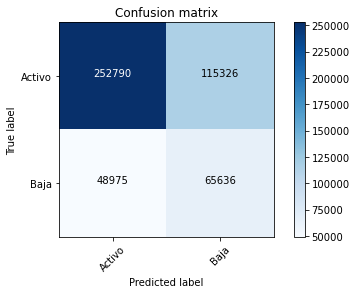

In [110]:
print(classification_report(y_test_naive,y_pred ))

cm = confusion_matrix(y_test_naive,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

### Regresión Logística

Logistic Accuracy is 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     73624
           1       0.52      0.78      0.62     22922

    accuracy                           0.78     96546
   macro avg       0.72      0.78      0.73     96546
weighted avg       0.82      0.78      0.79     96546



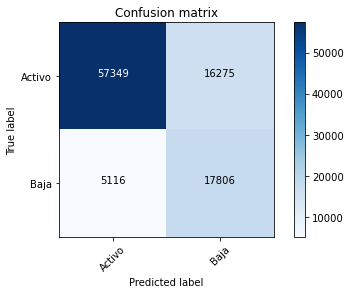

In [111]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state = 0, max_iter=1000, class_weight="balanced")
LR.fit(X_train,y_train) 
y_pred = LR.predict(X_test)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_LR = cross_val_score(LR, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_LR)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.86


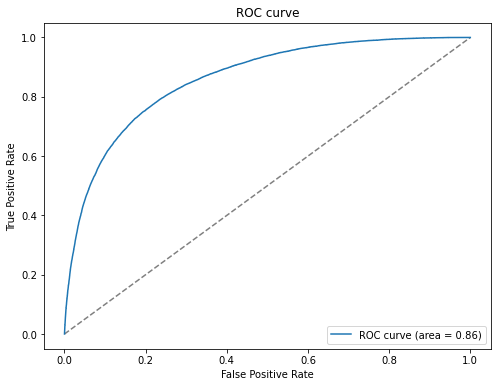

In [112]:
plot_roc_curve(LR, X_test, y_test)

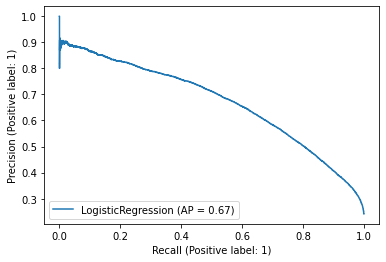

In [113]:
plot_precision_recall_curve(LR, X_test, y_test);

In [114]:
filename = '../pkl/LR_model.pkl'
LR_model = LR.fit(X_train, y_train)

pickle.dump(LR_model, open(filename,'wb'))

### Decission Tree Classifier

Decision Tree Accuracy is 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     73624
           1       0.53      0.78      0.63     22922

    accuracy                           0.78     96546
   macro avg       0.73      0.78      0.74     96546
weighted avg       0.83      0.78      0.80     96546



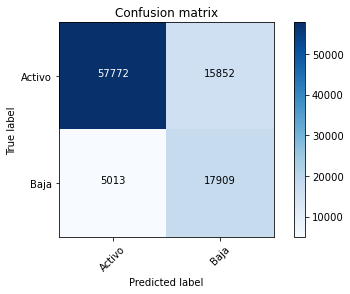

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

DT = DecisionTreeClassifier(random_state = 0,class_weight="balanced", min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_DT = cross_val_score(DT, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_DT)

y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.87


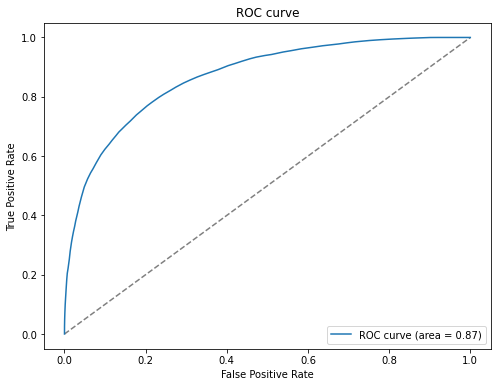

In [116]:
plot_roc_curve(DT, X_test, y_test)

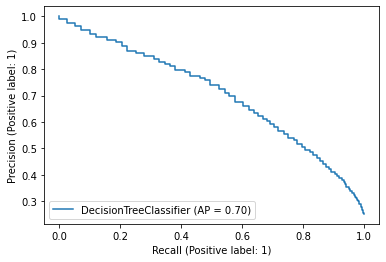

In [117]:
plot_precision_recall_curve(DT, X_test, y_test);

In [118]:
filename = '../pkl/DT_model.pkl'
DT_model = DT.fit(X_train, y_train)

pickle.dump(DT_model, open(filename,'wb'))

### Random Forest Classifier

Random Forest Accuracy is 0.86
Cross Validation Score = 0.86
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     73624
           1       0.70      0.69      0.70     22922

    accuracy                           0.86     96546
   macro avg       0.80      0.80      0.80     96546
weighted avg       0.86      0.86      0.86     96546



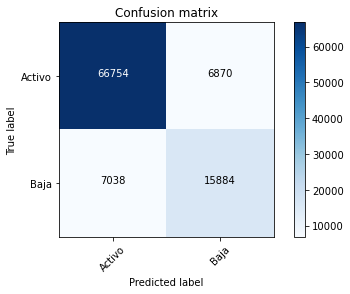

In [119]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=20)
score_rfc = cross_val_score(rfc, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc)

print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.90


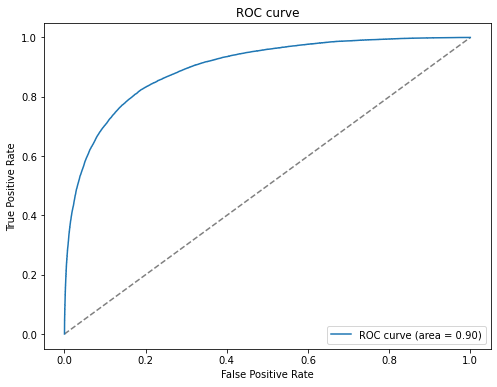

In [120]:
plot_roc_curve(rfc, X_test, y_test)

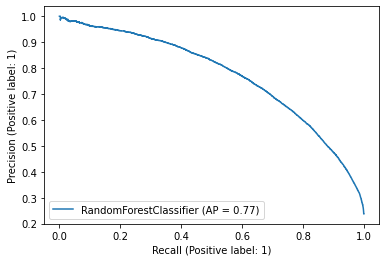

In [121]:
plot_precision_recall_curve(rfc, X_test, y_test);

#### Random Forest parameter tuning

{'bootstrap': False,  
 'max_depth': None,  
 'max_features': 'auto',  
 'min_samples_leaf': 3,  
 'min_samples_split': 5,  
 'n_estimators': 300}

Random Forest Accuracy is 0.85
Cross Validation Score = 0.85
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     73624
           1       0.68      0.72      0.70     22922

    accuracy                           0.85     96546
   macro avg       0.80      0.81      0.80     96546
weighted avg       0.86      0.85      0.85     96546



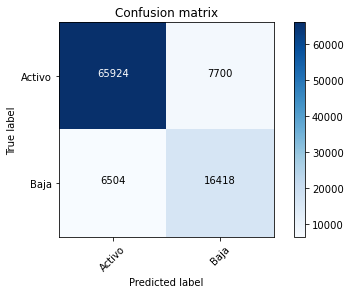

In [122]:
# Don´t do this!!!

from sklearn.ensemble import RandomForestClassifier

rfc_2 = RandomForestClassifier(min_samples_leaf = 3, 
                                       min_samples_split = 5,
                                       max_depth = None,
                                       n_estimators = 300, 
                                       max_features = 'auto', 
                                       bootstrap = False, class_weight = "balanced")
rfc_2.fit(X_train, y_train)
y_pred = rfc_2.predict(X_test)

print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=10)
score_rfc2 = cross_val_score(rfc_2, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc2)


print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [141]:
filename = '../pkl/rfc_model.pkl'
rfc_model = rfc.fit(X_train, y_train)

pickle.dump(rfc_model, open(filename,'wb'))

# rfc_2 ocupa 2 Gb en .pkl

ROC AUC score: 0.90


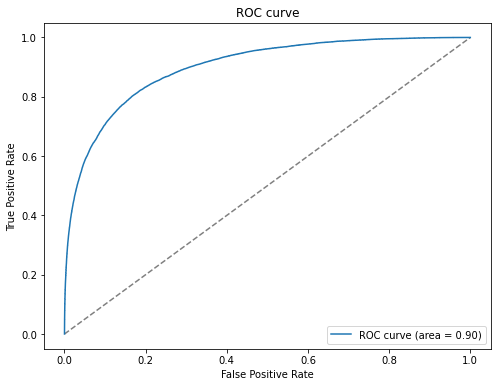

In [126]:
plot_roc_curve(rfc_2, X_test, y_test);

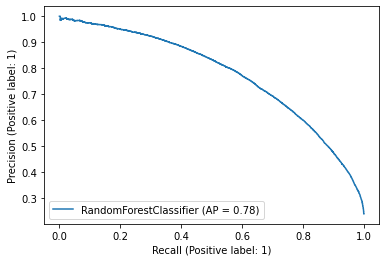

In [127]:
plot_precision_recall_curve(rfc_2, X_test, y_test);

### XGBoost

GradientBoost Accuracy= 0.86
Cross Validation Score = 0.86
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     73624
           1       0.79      0.58      0.67     22922

    accuracy                           0.86     96546
   macro avg       0.83      0.77      0.79     96546
weighted avg       0.86      0.86      0.86     96546



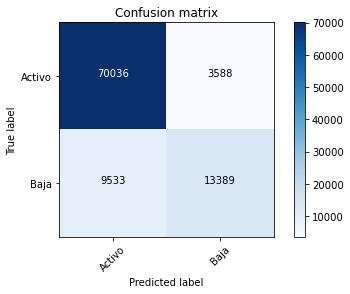

In [128]:
# Don´t do this!!!

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, booster='gbtree', learning_rate=0.01, objective='binary:logistic')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_xgb = cross_val_score(xgb, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_xgb)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.90


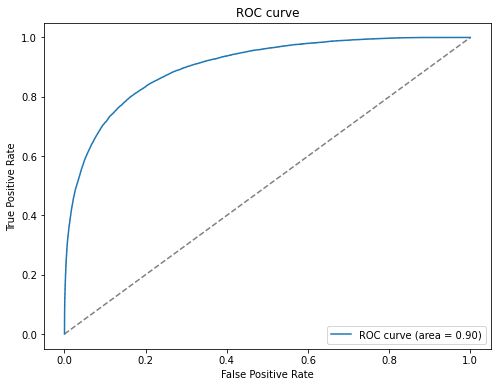

In [129]:
plot_roc_curve(xgb, X_test, y_test)

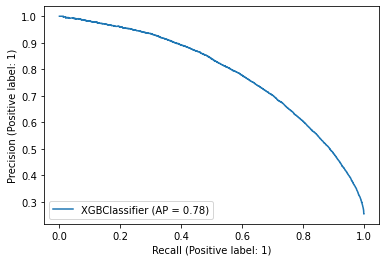

In [130]:
plot_precision_recall_curve(xgb, X_test, y_test);

In [131]:
filename = '../pkl/xgb_model.pkl'
xgb_model = xgb.fit(X_train, y_train)

pickle.dump(xgb_model, open(filename,'wb'))

### Voting Classifier

Utilizando Regresión Logística y Decission Tree Classifier.

VotingClassifier Accuracy= 0.79
Cross Validation Score = 0.80
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     73624
           1       0.55      0.79      0.64     22922

    accuracy                           0.79     96546
   macro avg       0.73      0.79      0.75     96546
weighted avg       0.83      0.79      0.80     96546



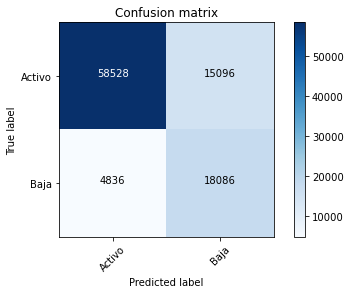

In [132]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
         ('lr', LR), ('dt', DT)],
         voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print ("VotingClassifier Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_voting_clf = cross_val_score(voting_clf, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_voting_clf)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [133]:
filename = '../pkl/voting_clf_model.pkl'
voting_clf_model = voting_clf.fit(X_train, y_train)

pickle.dump(voting_clf_model, open(filename,'wb'))

ROC AUC score: 0.88


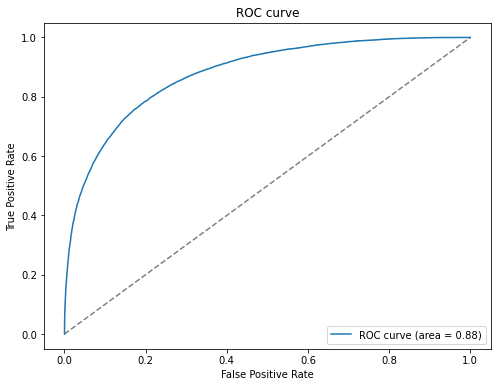

In [134]:
plot_roc_curve(voting_clf, X_test, y_test);

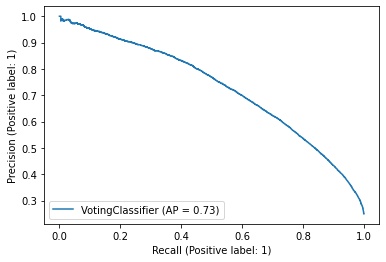

In [135]:
plot_precision_recall_curve(voting_clf, X_test, y_test);

### Comparing ROC Curves

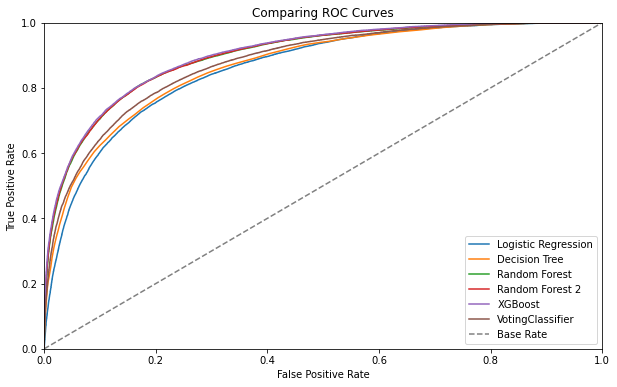

In [136]:
plt.figure(figsize = (10,6), linewidth= 1)

LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
rfc2_fpr, rfc2_tpr, thresholds = roc_curve(y_test, rfc_2.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
vc_fpr, vc_tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])

plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(rfc2_fpr, rfc2_tpr, label='Random Forest 2')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')
plt.plot(vc_fpr, vc_tpr, label='VotingClassifier')

plt.plot([0,1],[0,1],label='Base Rate', ls = '--', c = 'grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparing PR Curves

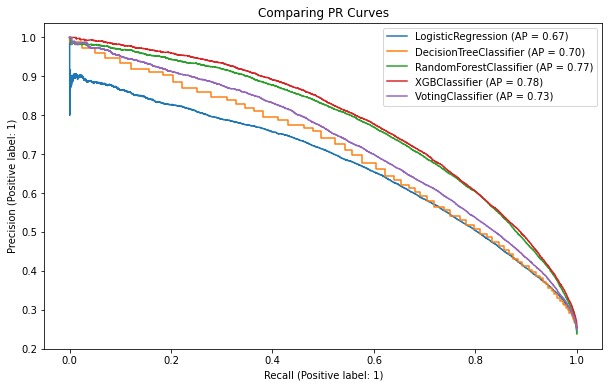

In [137]:
models = [LR, DT, rfc, xgb, voting_clf]

fig, ax = plt.subplots(figsize=(10, 6))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
    plt.legend(loc="upper right")
ax.set_title("Comparing PR Curves");

### Feature importances

In [138]:
from sklearn.feature_selection import RFE

# Using Recursive Feature Elimination Function and fitting it in a Logistic Regression Model
modell = LogisticRegression(max_iter=1000, class_weight="balanced")
rfe = RFE(modell, 5)
rfe = rfe.fit(X_train,y_train)

rfe.ranking_

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 6,  7,  8,  1, 11,  4, 10,  5,  1,  1,  9,  1,  1,  3,  2])

In [139]:
result = zip(X_train.columns, rfe.ranking_)

result_set = set(result)
print(result_set)

{('Pais', 10), ('Provincia', 4), ('Situacion Laboral', 1), ('Precio Contado', 1), ('Quejas_sca', 1), ('Rango_Edad', 5), ('Consumo_sca', 2), ('Pagos Anuales', 9), ('Income', 1), ('Tipo Propiedad', 8), ('Dias_Activo_sca', 1), ('Estado Civil', 11), ('Gender', 6), ('Tipo Inmueble', 7), ('Incidencias_sca', 3)}


[0.01834036 0.07191435 0.03474337 0.03859818 0.02481789 0.08947162
 0.0188313  0.05944657 0.0473523  0.05456935 0.02846752 0.23111822
 0.08876312 0.07327927 0.12028658]


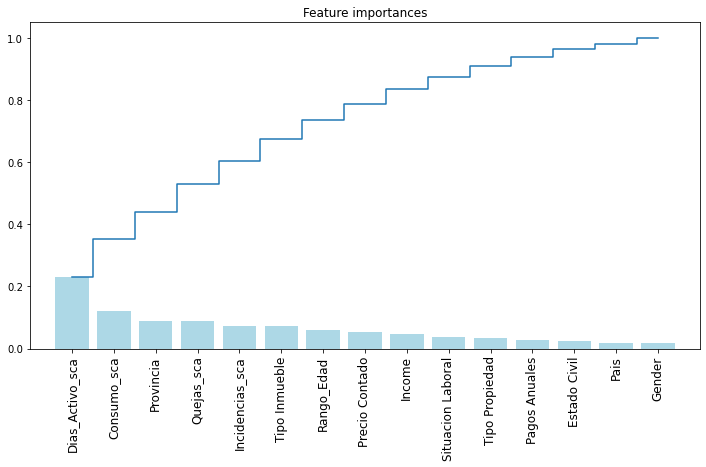

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Printing important features in the model
print(model.feature_importances_)
importances = model.feature_importances_
feat_names = data_filtered.drop(['Estado'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()